Regularization , embedding, bidirectrional LSTM, dropouts, and yet the effect of an extremely imbalanced dataset caused the model b

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import TextVectorization
import re

In [2]:
df = pd.read_csv('tweet_emotions.csv')

In [3]:
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [4]:
df['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [5]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  
    return text
df['content'] = df['content'].apply(clean_text) 

In [6]:
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [7]:
from sklearn.preprocessing import LabelEncoder

sentiment_labels = df['sentiment']
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(sentiment_labels)
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


{'anger': 0, 'boredom': 1, 'empty': 2, 'enthusiasm': 3, 'fun': 4, 'happiness': 5, 'hate': 6, 'love': 7, 'neutral': 8, 'relief': 9, 'sadness': 10, 'surprise': 11, 'worry': 12}


In [8]:
df['sentiment']=df['sentiment'].astype(int)

In [9]:
df.head()

,tweet_id,sentiment,content
0,1956967341,2,@tiffanylue i know i was listenin to bad habi...
1,1956967666,10,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,10,Funeral ceremony...gloomy friday...
3,1956967789,3,wants to hang out with friends SOON!
4,1956968416,8,@dannycastillo We want to trade with someone w...


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  int64 
 2   content    40000 non-null  object
dtypes: int64(2), object(1)
memory usage: 937.6+ KB


In [11]:
df.describe

<bound method NDFrame.describe of          tweet_id  sentiment  \
0      1956967341          2   
1      1956967666         10   
2      1956967696         10   
3      1956967789          3   
4      1956968416          8   
...           ...        ...   
39995  1753918954          8   
39996  1753919001          7   
39997  1753919005          7   
39998  1753919043          5   
39999  1753919049          7   

                                                 content  
0      @tiffanylue i know  i was listenin to bad habi...  
1      Layin n bed with a headache  ughhhh...waitin o...  
2                    Funeral ceremony...gloomy friday...  
3                   wants to hang out with friends SOON!  
4      @dannycastillo We want to trade with someone w...  
...                                                  ...  
39995                                   @JohnLloydTaylor  
39996                     Happy Mothers Day  All my love  
39997  Happy Mother's Day to all the mommies out t

In [12]:
 df.isnull().sum()

tweet_id     0
sentiment    0
content      0
dtype: int64

In [14]:
df.describe

<bound method NDFrame.describe of          tweet_id  sentiment  \
0      1956967341          2   
1      1956967666         10   
2      1956967696         10   
3      1956967789          3   
4      1956968416          8   
...           ...        ...   
39995  1753918954          8   
39996  1753919001          7   
39997  1753919005          7   
39998  1753919043          5   
39999  1753919049          7   

                                                 content  
0      @tiffanylue i know  i was listenin to bad habi...  
1      Layin n bed with a headache  ughhhh...waitin o...  
2                    Funeral ceremony...gloomy friday...  
3                   wants to hang out with friends SOON!  
4      @dannycastillo We want to trade with someone w...  
...                                                  ...  
39995                                   @JohnLloydTaylor  
39996                     Happy Mothers Day  All my love  
39997  Happy Mother's Day to all the mommies out t

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  int64 
 2   content    40000 non-null  object
dtypes: int64(2), object(1)
memory usage: 937.6+ KB


In [16]:
X = df['content']
y = df['sentiment']

In [17]:
X


0        @tiffanylue i know  i was listenin to bad habi...
1        Layin n bed with a headache  ughhhh...waitin o...
2                      Funeral ceremony...gloomy friday...
3                     wants to hang out with friends SOON!
4        @dannycastillo We want to trade with someone w...
                               ...                        
39995                                     @JohnLloydTaylor
39996                       Happy Mothers Day  All my love
39997    Happy Mother's Day to all the mommies out ther...
39998    @niariley WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEE...
39999    @mopedronin bullet train from tokyo    the gf ...
Name: content, Length: 40000, dtype: object

In [18]:
MAX_FEATURES = 150000

In [19]:
len(set(" ".join(df['content']).split()))

83297

In [20]:
df['text_length'] = df['content'].apply(lambda x: len(x.split()))


percentile_90 = np.percentile(df['text_length'], 90)
percentile_95 = np.percentile(df['text_length'], 95)

print(f"90th Percentile of text length: {percentile_90}")
print(f"95th Percentile of text length: {percentile_95}")

90th Percentile of text length: 23.0
95th Percentile of text length: 25.0


In [21]:
OUTPUT_SEQUENCE_LENGTH = int(percentile_95) + 20 

In [22]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
                               output_mode='int')

In [23]:
vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)

In [24]:
num_samples = df.shape[0]
print(f'Number of samples in the dataset: {num_samples}')


Number of samples in the dataset: 40000


In [25]:
buffer_size_shuffle = 50000 
buffer_size_prefetch = tf.data.experimental.AUTOTUNE  

dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=buffer_size_shuffle)
dataset = dataset.batch(16)  # Assuming a batch size of 16
dataset = dataset.prefetch(buffer_size=buffer_size_prefetch)


In [26]:
batch_x, batch_y = dataset.as_numpy_iterator().next()

In [27]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2


NUM_CLASSES = 13 

model = Sequential()
model.add(Embedding(input_dim=MAX_FEATURES + 1, output_dim=32, input_length=OUTPUT_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=32)))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(units=NUM_CLASSES, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),  
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 45, 32)            4800032   
                                                                 
 bidirectional_3 (Bidirecti  (None, 45, 128)           49664     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 45, 128)           0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [69]:
history = model.fit(train, validation_data=val, epochs=50)


test_loss, test_accuracy = model.evaluate(test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/50
1750/1750 [==============================] - 64s 37ms/step - loss: 1.1934 - accuracy: 0.6223 - val_loss: 0.9992 - val_accuracy: 0.6913
Epoch 2/50
1750/1750 [==============================] - 65s 37ms/step - loss: 1.0693 - accuracy: 0.6687 - val_loss: 0.9047 - val_accuracy: 0.7278
Epoch 3/50
1750/1750 [==============================] - 63s 36ms/step - loss: 0.9670 - accuracy: 0.7064 - val_loss: 0.8037 - val_accuracy: 0.7565
Epoch 4/50
1750/1750 [==============================] - 63s 36ms/step - loss: 0.8865 - accuracy: 0.7359 - val_loss: 0.7505 - val_accuracy: 0.7756
Epoch 5/50
1750/1750 [==============================] - 63s 36ms/step - loss: 0.8059 - accuracy: 0.7627 - val_loss: 0.6625 - val_accuracy: 0.8084
Epoch 6/50
1750/1750 [==============================] - 63s 36ms/step - loss: 0.7392 - accuracy: 0.7853 - val_loss: 0.5914 - val_accuracy: 0.8291
Epoch 7/50
1750/1750 [==============================] - 63s 36ms/step - loss: 0.6891 - accuracy: 0.7996 - val_loss: 0.5803 -

In [70]:
history.history

{'loss': [1.1933927536010742,
  1.0693165063858032,
  0.9669733643531799,
  0.8865355253219604,
  0.8059282898902893,
  0.7391692399978638,
  0.6891229152679443,
  0.6492123603820801,
  0.5976467728614807,
  0.5534510612487793,
  0.522557258605957,
  0.5027400851249695,
  0.48071321845054626,
  0.44412899017333984,
  0.4379845857620239,
  0.42021533846855164,
  0.40003320574760437,
  0.3778216242790222,
  0.35645318031311035,
  0.3446013331413269,
  0.33475461602211,
  0.3140125274658203,
  0.307011216878891,
  0.2983279228210449,
  0.288522869348526,
  0.28288522362709045,
  0.27144181728363037,
  0.2675512135028839,
  0.26209816336631775,
  0.25032952427864075,
  0.2475193440914154,
  0.2376457303762436,
  0.23206961154937744,
  0.22433733940124512,
  0.21596376597881317,
  0.20867447555065155,
  0.21352341771125793,
  0.20519892871379852,
  0.19898027181625366,
  0.19389091432094574,
  0.18868082761764526,
  0.184381902217865,
  0.17837992310523987,
  0.17908021807670593,
  0.164391

In [71]:
sample_text = ["i am so happy because i had a nice day"]
predictions = model.predict(vectorizer(sample_text))

1/1 [==============================] - 1s 839ms/step


In [72]:
predictions

array([[3.3526965e-05, 5.4533051e-05, 7.7162189e-03, 2.1986349e-02,
        1.6299589e-02, 1.7294894e-01, 4.7584489e-04, 2.7372951e-02,
        1.4668423e-01, 6.5117866e-02, 3.2449890e-02, 2.9493839e-02,
        4.7936624e-01]], dtype=float32)

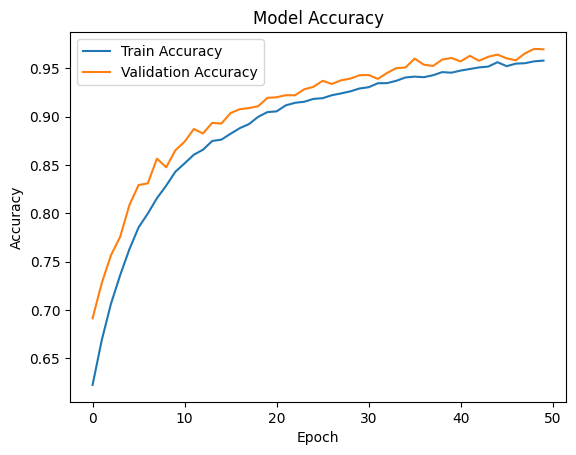

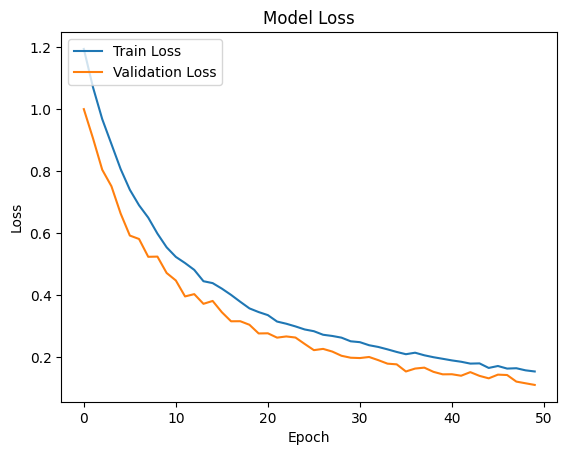

In [73]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

In [74]:
model.save('tweet_emotion_classifier.keras')

In [77]:
sample_texts = ["i will kill that bitch"]
predictions = model.predict(np.array([vectorizer(txt) for txt in sample_texts])) 

sentiment_classes = ['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'happiness', 
                     'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise', 'worry']

for txt, pred in zip(sample_texts, predictions):
 
    print(f"\nText: {txt}")
    for sentiment, probability in zip(sentiment_classes, pred):
        print(f"{sentiment}: {probability * 100:.2f}%")

1/1 [==============================] - 0s 16ms/step

Text: i will kill that bitch
anger: 0.02%
boredom: 0.24%
empty: 0.10%
enthusiasm: 0.22%
fun: 0.04%
happiness: 0.13%
hate: 34.95%
love: 3.90%
neutral: 5.81%
relief: 0.07%
sadness: 46.72%
surprise: 4.07%
worry: 3.74%


250/250 [==============================] - 2s 5ms/step


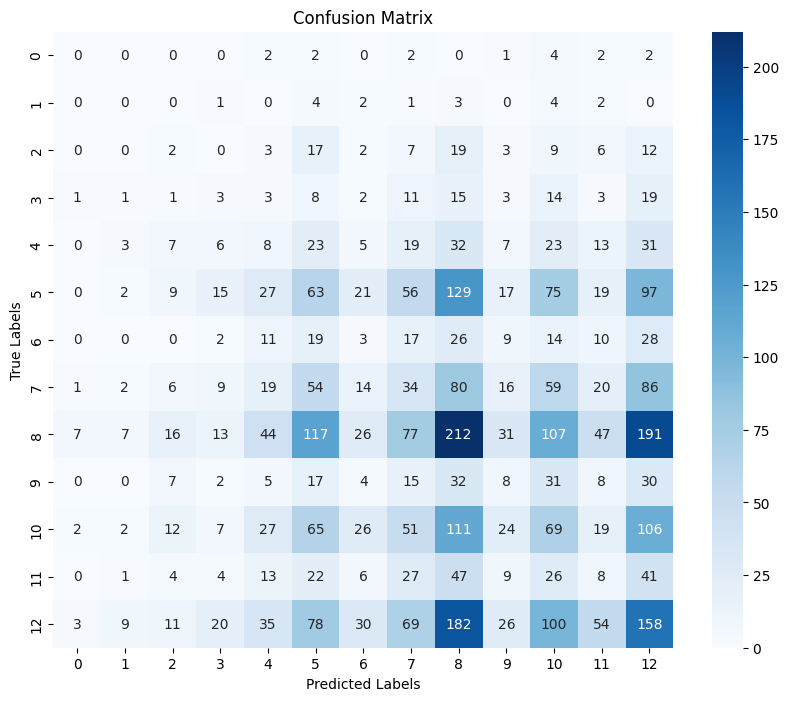

In [78]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


y_pred_probs = model.predict(test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test], axis=0)
conf_matrix = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [79]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  

recall = recall_score(y_true, y_pred, average='weighted') 

f1 = f1_score(y_true, y_pred, average='weighted') 

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.1420
Precision: 0.1422
Recall: 0.1420
F1 Score: 0.1420
